# Token Cloud Extent: Eigenvector Cross-Sections

**Goal:** Visualize the extent of the token cloud along each eigenvector direction.

**Previous finding (09.3a):** Tokens are perpendicular (≈90°) to 99.7% of eigenvectors, with notable exceptions:
- **Rank 0** (smallest eigenvalue): mean angle 75° → tokens CLUSTER in this direction
- **Ranks 2557-2559** (largest eigenvalues): mean angles 88-93° → tokens AVOID these directions

**Question:** How far does the cloud extend along each eigenvector direction?

**Method:**
1. For each eigenvector: project all tokens onto it (in causal distance units)
2. Find max extent (furthest token in positive direction)
3. Find min extent (furthest token in negative direction)
4. Plot as cross-sectional envelope across all 2,560 eigenvector ranks

**Visualization:**
- **X-axis:** Eigenvector rank (0 to 2559)
- **Y-axis:** Signed distance from origin (logometers)
- **Upper curve:** Maximum extent in each direction
- **Lower curve:** Minimum extent in each direction
- **Shaded area:** Full diameter in that direction

Each vertical slice shows the cloud's extent along that eigendirection.

## Configuration

In [15]:
# Data paths
PROJECTIONS_PATH = '../data/vectors/token_eigenbasis_projections_qwen3_4b.pt'
EIGENBASIS_PATH = '../data/vectors/eigenbasis_qwen3_4b.pt'

# Special eigenvectors to highlight
SPECIAL_RANKS = {
    0: "Rank 0 (smallest λ, tokens cluster)",
    2557: "Rank 2557 (4th largest λ)",
    2558: "Rank 2558 (3rd largest λ)",
    2559: "Rank 2559 (largest λ, tokens avoid)"
}

print(f"Configuration:")
print(f"  Special eigenvectors: {list(SPECIAL_RANKS.keys())}")

Configuration:
  Special eigenvectors: [0, 2557, 2558, 2559]


## Setup

In [16]:
import numpy as np
import torch
import matplotlib.pyplot as plt

print("✓ Imports complete")

✓ Imports complete


## Load Precomputed Data

In [17]:
print("Loading precomputed data...\n")

# Load eigenbasis
print(f"Loading eigenbasis from {EIGENBASIS_PATH}...")
eigenbasis_data = torch.load(EIGENBASIS_PATH, weights_only=False)
eigenvalues = eigenbasis_data['eigenvalues']

# Load token projections
print(f"Loading token projections from {PROJECTIONS_PATH}...")
projections_data = torch.load(PROJECTIONS_PATH, weights_only=False)
projections = projections_data['projections']  # [vocab_size, hidden_dim]

vocab_size, hidden_dim = projections.shape

print(f"\n✓ Data loaded")
print(f"  Vocab size: {vocab_size:,}")
print(f"  Hidden dim: {hidden_dim:,}")
print(f"  Projections shape: {projections.shape}")

Loading precomputed data...

Loading eigenbasis from ../data/vectors/eigenbasis_qwen3_4b.pt...
Loading token projections from ../data/vectors/token_eigenbasis_projections_qwen3_4b.pt...

✓ Data loaded
  Vocab size: 151,936
  Hidden dim: 2,560
  Projections shape: torch.Size([151936, 2560])


---

# Compute Cloud Extent Along Each Eigenvector

For each eigenvector **v_i**, we need to:
1. Convert projections to **causal distance units** by scaling by sqrt(λᵢ)
2. Find max and min (furthest extents in positive/negative directions)
3. Compute diameter (max - min)

**Why sqrt(λᵢ)?** The causal norm is ||v||²_M = Σ λᵢ·(proj_i)², so distance scales as sqrt(λᵢ) along each eigendirection.

In [18]:
print("\n" + "=" * 80)
print("COMPUTING CLOUD EXTENT ALONG ALL EIGENVECTORS")
print("=" * 80)

print(f"\nComputing extent for each of {hidden_dim:,} eigenvectors...")

# Convert to numpy
projections_np = projections.numpy()
eigenvalues_np = eigenvalues.numpy()

# Compute max/min extent along each eigenvector (in causal distance units)
max_extent = np.zeros(hidden_dim)
min_extent = np.zeros(hidden_dim)
diameters = np.zeros(hidden_dim)

for i in range(hidden_dim):
    # Projections in eigenbasis coordinates
    proj_i = projections_np[:, i]
    
    # Convert to causal distance: scale by sqrt(eigenvalue)
    scale = np.sqrt(eigenvalues_np[i])
    causal_proj_i = scale * proj_i
    
    # Max and min extents
    max_extent[i] = causal_proj_i.max()
    min_extent[i] = causal_proj_i.min()
    diameters[i] = max_extent[i] - min_extent[i]

print(f"✓ Extents computed (in causal distance units: logometers)\n")

# Summary statistics
print(f"Diameter statistics (logometers):")
print(f"  Min: {diameters.min():.2f}")
print(f"  Max: {diameters.max():.2f}")
print(f"  Mean: {diameters.mean():.2f}")
print(f"  Median: {np.median(diameters):.2f}")
print(f"  Std: {diameters.std():.2f}")
print(f"  CV: {(diameters.std() / diameters.mean() * 100):.1f}%")

print(f"\nMax extent statistics (logometers):")
print(f"  Range: [{max_extent.min():.2f}, {max_extent.max():.2f}]")
print(f"  Mean: {max_extent.mean():.2f}")

print(f"\nMin extent statistics (logometers):")
print(f"  Range: [{min_extent.min():.2f}, {min_extent.max():.2f}]")
print(f"  Mean: {min_extent.mean():.2f}")


COMPUTING CLOUD EXTENT ALONG ALL EIGENVECTORS

Computing extent for each of 2,560 eigenvectors...
✓ Extents computed (in causal distance units: logometers)

Diameter statistics (logometers):
  Min: 7.28
  Max: 58.84
  Mean: 11.03
  Median: 10.02
  Std: 4.24
  CV: 38.4%

Max extent statistics (logometers):
  Range: [-5.77, 47.70]
  Mean: 5.53

Min extent statistics (logometers):
  Range: [-45.70, -3.77]
  Mean: -5.51


## Special Eigenvectors: Detailed View

In [19]:
print("\n" + "=" * 80)
print("SPECIAL EIGENVECTORS: EXTENT ANALYSIS")
print("=" * 80)

mean_diameter = diameters.mean()

print(f"\n{'Rank':<6} {'Eigenvalue':<15} {'Min':<10} {'Max':<10} {'Diameter':<12} {'vs. Mean':<12} {'Description'}")
print("=" * 100)

for rank in sorted(SPECIAL_RANKS.keys()):
    eigenval = eigenvalues[rank].item()
    min_ext = min_extent[rank]
    max_ext = max_extent[rank]
    diameter = diameters[rank]
    deviation = diameter - mean_diameter
    percent = (deviation / mean_diameter) * 100
    
    print(f"{rank:<6} {eigenval:>14,.0f} {min_ext:>9.2f} {max_ext:>9.2f} {diameter:>11.2f} {deviation:>+10.2f} ({percent:>+5.1f}%)  {SPECIAL_RANKS[rank]}")

print(f"\nMean diameter: {mean_diameter:.2f} logometers")


SPECIAL EIGENVECTORS: EXTENT ANALYSIS

Rank   Eigenvalue      Min        Max        Diameter     vs. Mean     Description
0                  95     -7.86      7.09       14.95      +3.91 (+35.5%)  Rank 0 (smallest λ, tokens cluster)
2557           24,434    -15.42      8.07       23.50     +12.46 (+112.9%)  Rank 2557 (4th largest λ)
2558           73,918     -8.33      9.35       17.68      +6.65 (+60.2%)  Rank 2558 (3rd largest λ)
2559           94,218    -32.34     -5.77       26.57     +15.53 (+140.8%)  Rank 2559 (largest λ, tokens avoid)

Mean diameter: 11.03 logometers


---

# Cross-Sectional Envelope Plot

Visualize the token cloud's extent as cross-sections through each eigenvector direction.

**How to read this plot:**
- Each vertical slice shows the cloud's extent along one eigenvector
- Upper curve: furthest token in positive direction
- Lower curve: furthest token in negative direction
- Shaded area: full diameter (height of vertical slice)
- Symmetry about X-axis: cloud is centered at origin in that direction


CREATING CROSS-SECTIONAL ENVELOPE PLOT


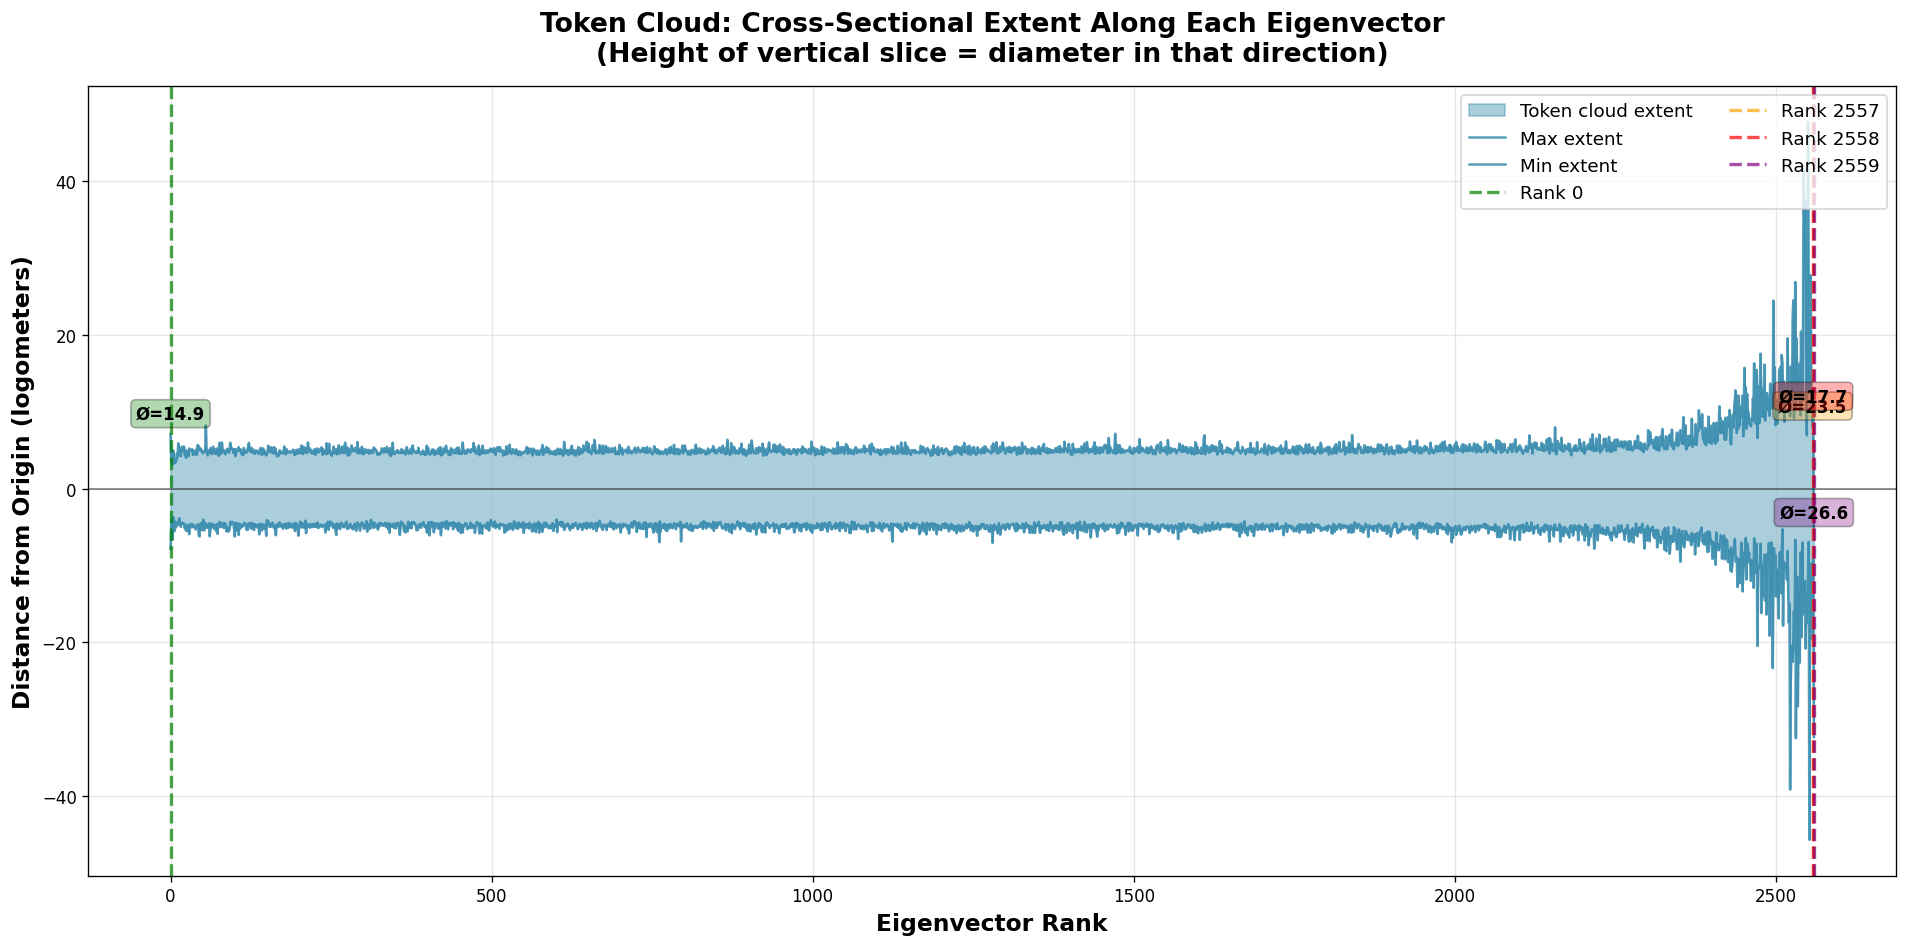


✓ Cross-sectional envelope plot created


In [20]:
print("\n" + "=" * 80)
print("CREATING CROSS-SECTIONAL ENVELOPE PLOT")
print("=" * 80)

# X-axis: eigenvector ranks
ranks = np.arange(hidden_dim)

# Create figure
fig, ax = plt.subplots(figsize=(16, 8), dpi=120)

# Plot envelope (shaded area between min and max)
ax.fill_between(ranks, min_extent, max_extent, 
                alpha=0.4, color='#2E86AB', label='Token cloud extent')

# Plot upper and lower bounds
ax.plot(ranks, max_extent, linewidth=1.5, color='#2E86AB', alpha=0.8, label='Max extent')
ax.plot(ranks, min_extent, linewidth=1.5, color='#2E86AB', alpha=0.8, label='Min extent')

# Add zero line (origin)
ax.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)

# Highlight special eigenvectors
colors = {0: 'green', 2557: 'orange', 2558: 'red', 2559: 'purple'}
for rank in SPECIAL_RANKS.keys():
    ax.axvline(rank, color=colors[rank], linestyle='--', linewidth=2, alpha=0.7,
               label=f'Rank {rank}')

# Configure plot
ax.set_xlabel('Eigenvector Rank', fontsize=14, fontweight='bold')
ax.set_ylabel('Distance from Origin (logometers)', fontsize=14, fontweight='bold')
ax.set_title('Token Cloud: Cross-Sectional Extent Along Each Eigenvector\n(Height of vertical slice = diameter in that direction)',
             fontsize=16, fontweight='bold', pad=15)
ax.legend(loc='upper right', fontsize=11, ncol=2)
ax.grid(True, alpha=0.3)

# Add annotations for special ranks
for rank in SPECIAL_RANKS.keys():
    diameter = diameters[rank]
    y_pos = max_extent[rank] + 2
    ax.text(rank, y_pos, f'Ø={diameter:.1f}', 
            ha='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor=colors[rank], alpha=0.3))

plt.tight_layout()
plt.show()

print("\n✓ Cross-sectional envelope plot created")

## Zoomed View: Special Eigenvectors

Focus on the regions around special eigenvectors to see detail.


Creating zoomed views for special eigenvectors...


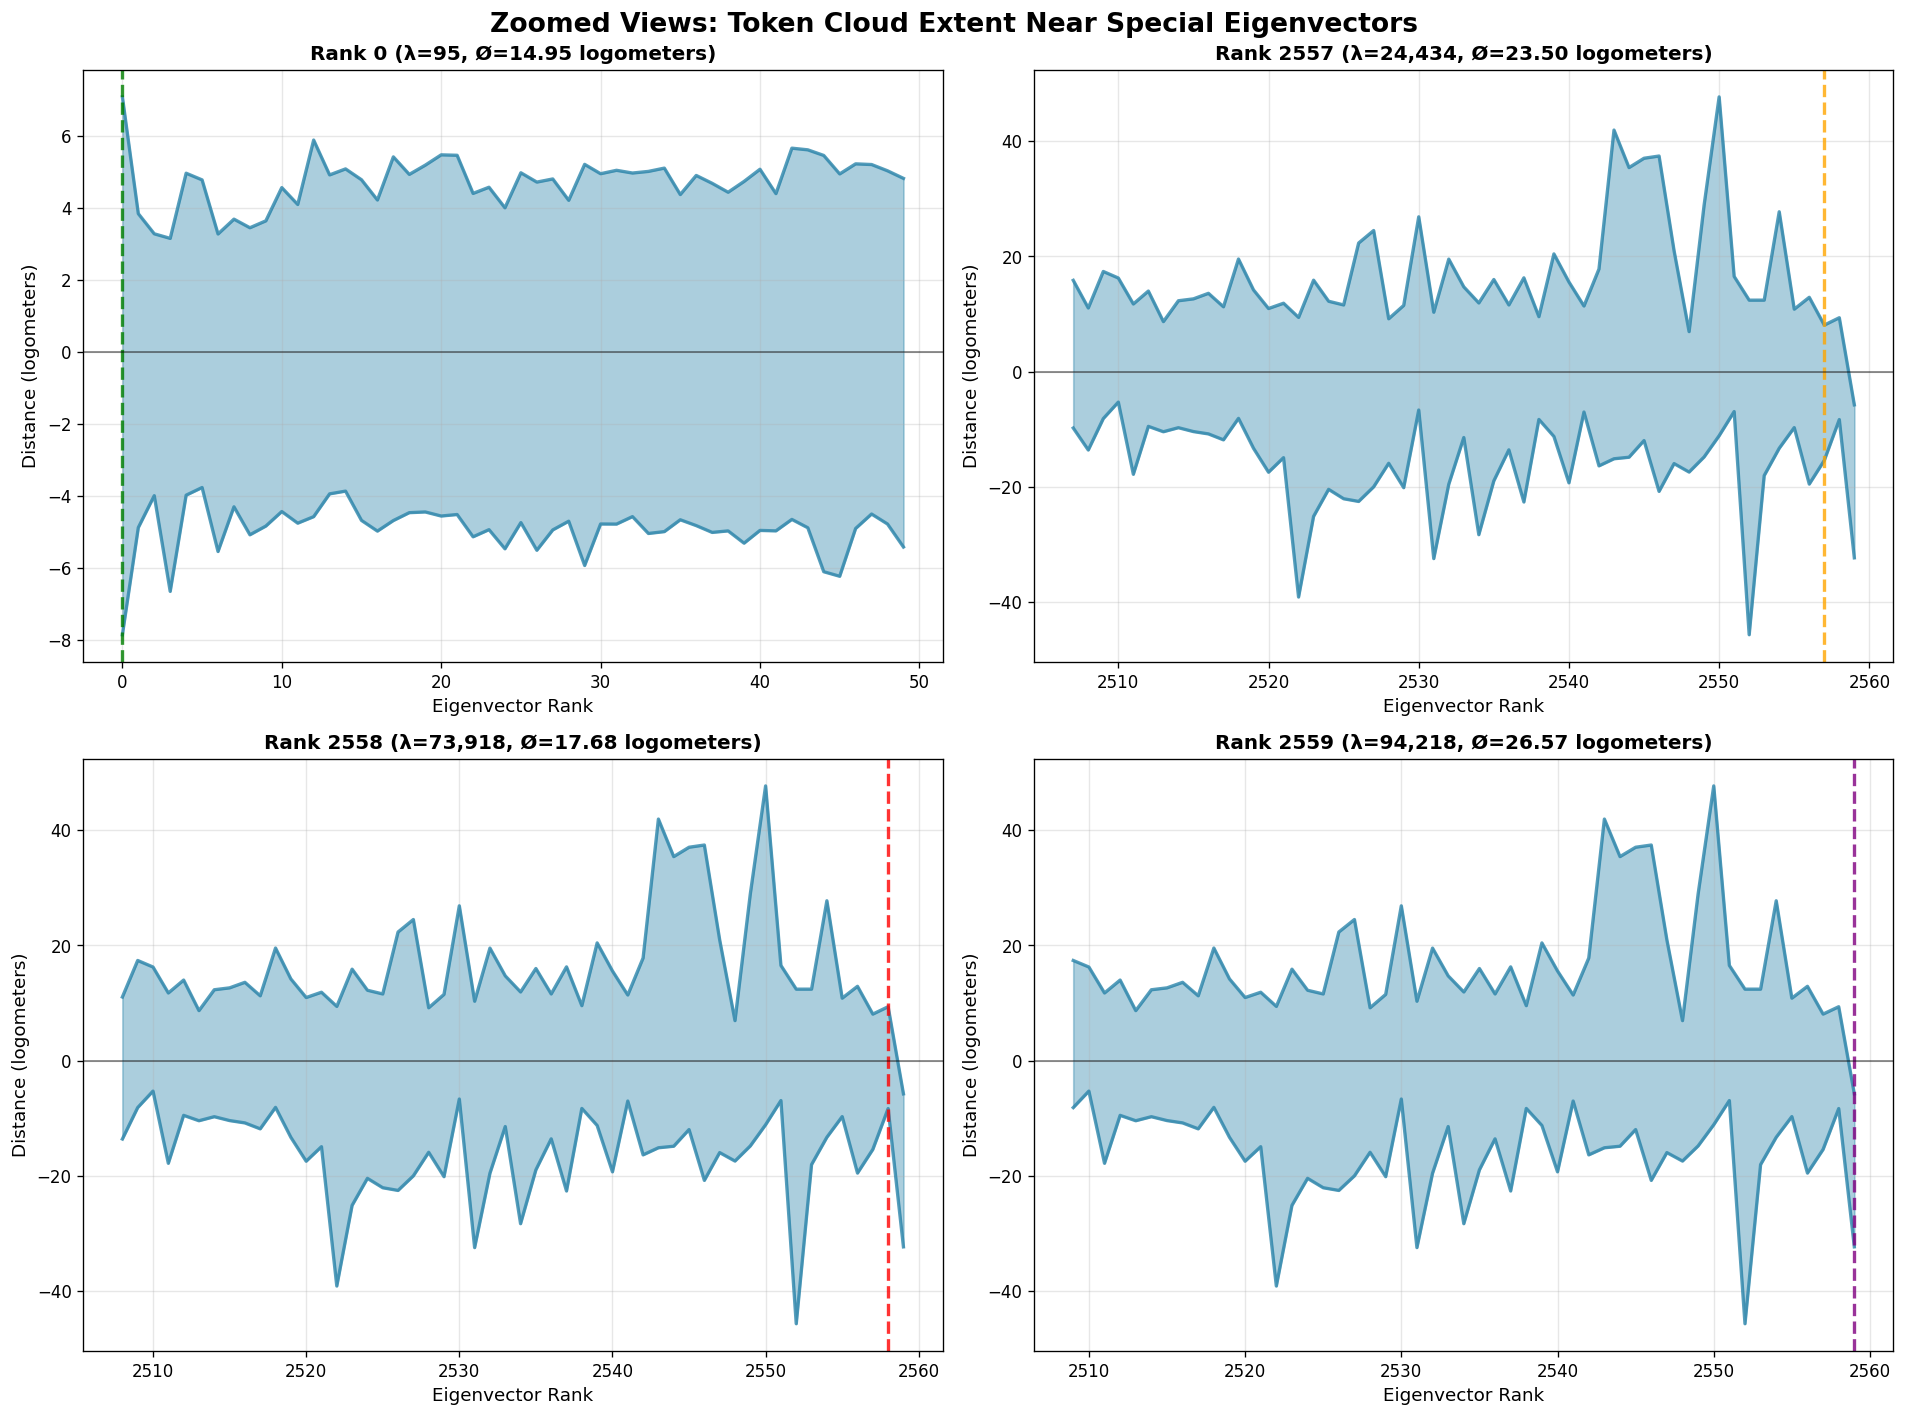

✓ Zoomed views created


In [21]:
print("\nCreating zoomed views for special eigenvectors...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=120)
axes = axes.flatten()

# Zoom window size
window = 50

for idx, rank in enumerate(sorted(SPECIAL_RANKS.keys())):
    ax = axes[idx]
    
    # Window around this rank
    start = max(0, rank - window)
    end = min(hidden_dim, rank + window)
    zoom_ranks = np.arange(start, end)
    
    # Plot envelope
    ax.fill_between(zoom_ranks, min_extent[start:end], max_extent[start:end],
                    alpha=0.4, color='#2E86AB')
    ax.plot(zoom_ranks, max_extent[start:end], linewidth=2, color='#2E86AB', alpha=0.8)
    ax.plot(zoom_ranks, min_extent[start:end], linewidth=2, color='#2E86AB', alpha=0.8)
    
    # Highlight this eigenvector
    ax.axvline(rank, color=colors[rank], linestyle='--', linewidth=2, alpha=0.8)
    
    # Zero line
    ax.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    
    # Labels
    eigenval = eigenvalues[rank].item()
    diameter = diameters[rank]
    ax.set_title(f'Rank {rank} (λ={eigenval:,.0f}, Ø={diameter:.2f} logometers)',
                fontsize=12, fontweight='bold')
    ax.set_xlabel('Eigenvector Rank', fontsize=11)
    ax.set_ylabel('Distance (logometers)', fontsize=11)
    ax.grid(True, alpha=0.3)

plt.suptitle('Zoomed Views: Token Cloud Extent Near Special Eigenvectors',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Zoomed views created")

## Diameter Distribution Histogram


Creating diameter distribution histogram...


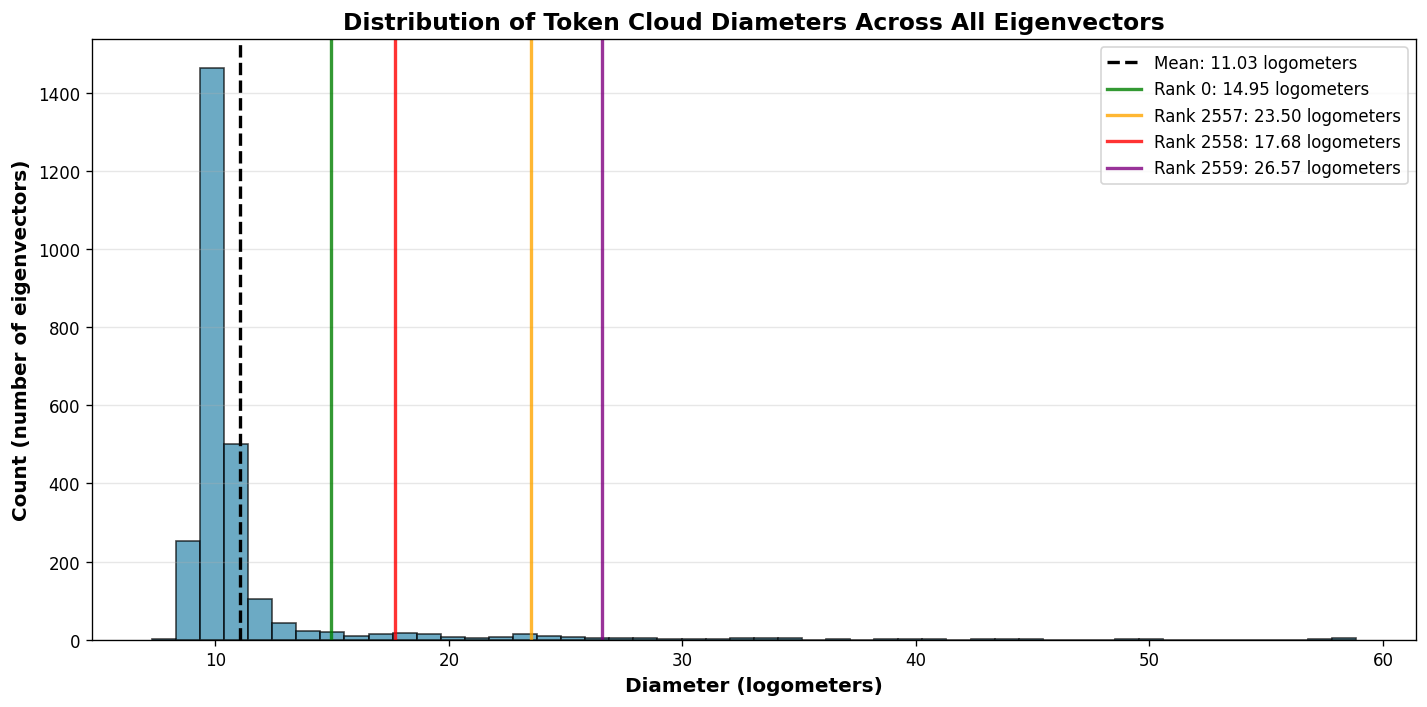

✓ Histogram created


In [22]:
print("\nCreating diameter distribution histogram...")

fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

# Histogram
counts, bins, patches = ax.hist(diameters, bins=50, color='#2E86AB', alpha=0.7, edgecolor='black')

# Mark mean
ax.axvline(mean_diameter, color='black', linestyle='--', linewidth=2,
           label=f'Mean: {mean_diameter:.2f} logometers')

# Mark special eigenvectors
for rank in SPECIAL_RANKS.keys():
    diameter = diameters[rank]
    ax.axvline(diameter, color=colors[rank], linestyle='-', linewidth=2,
               label=f'Rank {rank}: {diameter:.2f} logometers', alpha=0.8)

ax.set_xlabel('Diameter (logometers)', fontsize=12, fontweight='bold')
ax.set_ylabel('Count (number of eigenvectors)', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Token Cloud Diameters Across All Eigenvectors',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("✓ Histogram created")

---

# Summary

**What we measured:** The extent of the token cloud along each of the 2,560 eigenvector directions in causal distance units (logometers).

**Key findings:**
- [Run notebook to see results!]

**Interpretation:**
- **Cross-sectional envelope plot** shows the cloud's "silhouette" as you slice through each eigendirection
- Vertical slice height = diameter in that direction
- Symmetry about X-axis indicates cloud is centered at origin
- Variation in slice height shows anisotropy (different extents in different directions)

**Physical picture:**
The token cloud is NOT a perfect sphere. The cross-sectional envelope reveals:
- Which directions are stretched (larger diameters)
- Which directions are compressed (smaller diameters)
- Whether the cloud is centered or offset in any direction
- How much anisotropy exists (variation in diameter across eigenvectors)

This geometric structure emerges from gradient descent during training.